#1. Preparation

In [1]:
!pip install geopandas

     |████████████████████████████████| 972kB 6.6MB/s 
     |████████████████████████████████| 14.8MB 323kB/s 
     |████████████████████████████████| 6.5MB 36.6MB/s 


In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import datetime
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neural_network import MLPRegressor
import operator
import geopandas
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/11-29-2020.csv')

In [5]:
confirmed_df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20,11/24/20,11/25/20,11/26/20,11/27/20,11/28/20,11/29/20,11/30/20,12/1/20,12/2/20,12/3/20,12/4/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,40937,41032,41145,41268,41334,41425,41501,41633,41728,41814,41935,41975,42033,42159,42297,42463,42609,42795,42969,43035,43240,43468,43681,43924,44177,44363,44503,44706,44988,45174,45384,45600,45723,45844,46116,46274,46516,46718,46837,46837
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,19445,19729,20040,20315,20634,20875,21202,21523,21904,22300,22721,23210,23705,24206,24731,25294,25801,26211,26701,27233,27830,28432,29126,29837,30623,31459,32196,32761,33556,34300,34944,35600,36245,36790,37625,38182,39014,39719,40501,41302
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,56419,56706,57026,57332,57651,57942,58272,58574,58979,59527,60169,60800,61381,62051,62693,63446,64257,65108,65975,66819,67679,68589,69591,70629,71652,72755,73774,74862,75867,77000,78025,79110,80168,81212,82221,83199,84152,85084,85927,86730
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4325,4410,4517,4567,4665,4756,4825,4888,4910,5045,5135,5135,5319,5383,5437,5477,5567,5616,5725,5725,5872,5914,5951,6018,6066,6142,6207,6256,6304,6351,6428,6534,6610,6610,6712,6745,6790,6842,6904,6955
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,9644,9871,10074,10269,10558,10805,11035,11228,11577,11813,12102,12223,12335,12433,12680,12816,12953,13053,13228,13374,13451,13615,13818,13922,14134,14267,14413,14493,14634,14742,14821,14920,15008,15087,15103,15139,15251,15319,15361,15493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,50952,51528,51948,52571,53075,53520,54060,54775,55408,56090,56672,57226,57657,58158,58838,59422,60065,60784,61514,62167,63031,63867,64935,66186,67296,68768,70254,71644,73196,75007,76727,78493,80429,81890,83585,85647,88004,90192,92708,94676
267,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
268,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2060,2060,2061,2062,2062,2063,2063,2063,2063,2063,2063,2067,2070,2070,2071,2071,2071,2071,2072,2072,2072,2078,2081,2083,2086,2090,2093,2099,2107,2114,2124,2137,2148,2160,2177,2191,2197,2217,2239,2267
269,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,16200,16243,16285,16325,16415,16432,16480,16543,16661,16698,16770,16819,16908,16954,16971,16997,17036,17056,17093,17097,17123,17187,17243,17280,17350,17373,17394,17424,17454,17466,17535,17553,17569,17589,17608,17647,17665,17700,17730,17857


#2. Wrangling

In [6]:
cols = list(confirmed_df.columns)

In [7]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]


In [8]:
dates = confirmed.columns
world_cases = []
total_deaths = [] 
total_recovered = [] 
total_active = [] 
mortality_rate = []
recovery_rate = [] 


for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)

In [9]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i:i+window_size]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average

# window size
window = 7

# confirmed cases
world_daily_increase = daily_increase(world_cases)
world_confirmed_avg= moving_average(world_cases, window)
world_daily_increase_avg = moving_average(world_daily_increase, window)

# deaths
world_daily_death = daily_increase(total_deaths)
world_death_avg = moving_average(total_deaths, window)
world_daily_death_avg = moving_average(world_daily_death, window)

# recoveries
world_daily_recovery = daily_increase(total_recovered)
world_recovery_avg = moving_average(total_recovered, window)
world_daily_recovery_avg = moving_average(world_daily_recovery, window)

# active 
world_active_avg = moving_average(total_active, window)

In [10]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases_array = np.array(world_cases).reshape(-1, 1)
total_deaths_array = np.array(total_deaths).reshape(-1, 1)
total_recovered_array = np.array(total_recovered).reshape(-1, 1)

In [11]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

In [12]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [13]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22[50:], world_cases_array[50:], test_size=0.05, shuffle=False) 

#3. Modelling

##SVM

In [14]:
'''
c = [0.01, 0.1, 1]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
degree = [3, 4, 5]

svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking, 'degree': degree}

svm = SVR(kernel='poly')
svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
svm_search.fit(X_train_confirmed, y_train_confirmed)
'''

"\nc = [0.01, 0.1, 1]\ngamma = [0.01, 0.1, 1]\nepsilon = [0.01, 0.1, 1]\nshrinking = [True, False]\ndegree = [3, 4, 5]\n\nsvm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking, 'degree': degree}\n\nsvm = SVR(kernel='poly')\nsvm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)\nsvm_search.fit(X_train_confirmed, y_train_confirmed)\n"

In [15]:
#svm_search.best_params_

In [16]:
#svm_confirmed = svm_search.best_estimator_
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

MAE: 287159.59300985717
MSE: 89109591160.3368


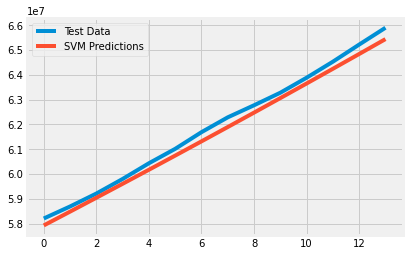

In [17]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

##Polynomial Feature for Linear Regression and Bayesian Ridge Regression

In [18]:
poly = PolynomialFeatures(degree=5)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

bayesian_poly = PolynomialFeatures(degree=5)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train_confirmed)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test_confirmed)
bayesian_poly_future_forcast = bayesian_poly.fit_transform(future_forcast)

##Polynomial Regression

In [19]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 1657128.6162267753
MSE: 3609522417770.6304


In [20]:
print(linear_model.coef_)

[[-2.35775839e+07  9.25417687e+05 -1.33630181e+04  9.33815040e+01
  -2.89812818e-01  3.41776409e-04]]


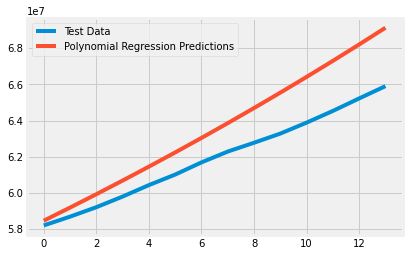

In [21]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

##Bayesian Ridge Polynomial Regression

In [22]:
# bayesian ridge polynomial regression
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
normalize = [True, False]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 
                 'normalize' : normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.4s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=False,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=False, tol=0.001,
                                           verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                  

In [23]:
bayesian_search.best_params_

{'alpha_1': 1e-07,
 'alpha_2': 1e-05,
 'lambda_1': 0.001,
 'lambda_2': 1e-07,
 'normalize': False,
 'tol': 1e-06}

In [24]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(bayesian_poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(bayesian_poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 1513051.9520305747
MSE: 2304822217649.2666


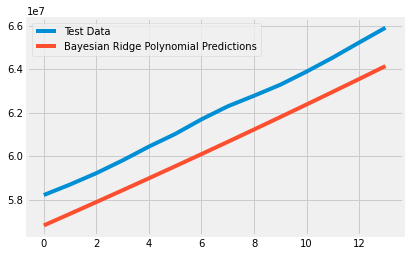

In [25]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

#Visualization

In [26]:
#PLOTS
 
#world confirmed cases
#world death cases
#world recovered cases
#world active cases
#world mortality rate
#world recovery rate
#world daily average confirmed increase
#world daily average death increase
#world daily average recovered increase
#all countries (table)
#all countries (piechart)
 
#indonesian confirmed cases
#indonesian death cases
#indonesian recovered cases
#indonesian active cases
#indonesian mortality rate
#indonesian recovery rate
#indonesian daily average confirmed increase
#indonesian daily average death increase
#indonesian daily average recovered increase
 
#neighbor confirmed cases
#neighbor death cases
#neighbor recovered cases
 
#gif world confirmed cases
#gif world confirmed cases per capita
#gif world active cases
#gif world active cases per capita
 
#prediksi world confirmed cases
#prediksi indonesian confirmed cases


In [27]:
# moving the columns into rows using dataframe’s melt function
new_df = confirmed_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name="Date", value_name="Confirmed")
#drop unnecessary columns
#new_df = new_df.drop(['Province/State','Lat','Long'],axis=1)
new_df = new_df.drop(['Province/State'],axis=1)
# for some countries there are multiple rows since the province data was populated, we need 
# to group by country and date after the province column is dropped
new_df = new_df.groupby(['Country/Region','Date']).sum()
new_df = new_df.reset_index()

# moving the columns into rows using dataframe’s melt function
new_death_df = deaths_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name="Date", value_name="Death")
#drop unnecessary columns
#new_death_df = new_death_df.drop(['Province/State','Lat','Long'],axis=1)
new_death_df = new_death_df.drop(['Province/State'],axis=1)
# for some countries there are multiple rows since the province data was populated, we need 
# to group by country and date after the province column is dropped
new_death_df = new_death_df.groupby(['Country/Region','Date']).sum()
new_death_df = new_death_df.reset_index()
new_death_df = new_death_df.Death

new_df = new_df.join(new_death_df)
new_df

# moving the columns into rows using dataframe’s melt function
new_recoveries_df = recoveries_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name="Date", value_name="Recoveries")
#drop unnecessary columns
#new_recoveries_df = new_recoveries_df.drop(['Province/State','Lat','Long'],axis=1)
new_recoveries_df = new_recoveries_df.drop(['Province/State'],axis=1)
# for some countries there are multiple rows since the province data was populated, we need 
# to group by country and date after the province column is dropped
new_recoveries_df = new_recoveries_df.groupby(['Country/Region','Date']).sum()
new_recoveries_df = new_recoveries_df.reset_index()
new_recoveries_df = new_recoveries_df.Recoveries

new_df = new_df.join(new_recoveries_df)

new_df[new_df['Country/Region']=='Republic Congo']

,Country/Region,Date,Lat,Long,Confirmed,Death,Recoveries


##World Confirmed Cases

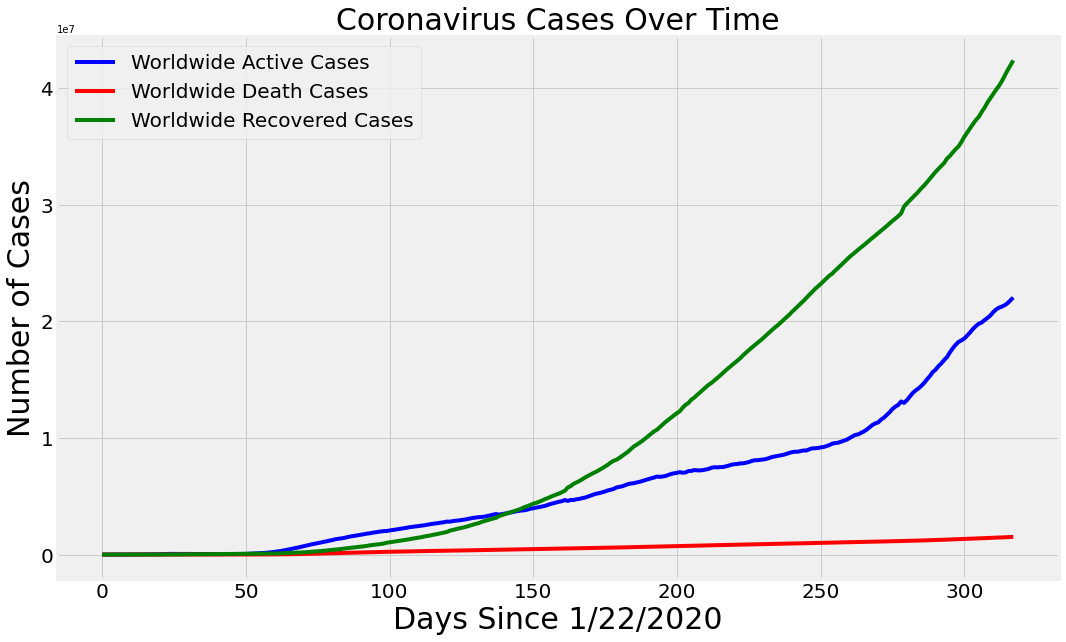

In [28]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, total_active,color='blue')
#plt.plot(adjusted_dates, world_cases)
plt.plot(adjusted_dates, total_deaths,color='red')
plt.plot(adjusted_dates, total_recovered, color='green')
#plt.plot(adjusted_dates, world_cases)
#plt.plot(adjusted_dates, world_confirmed_avg, linestyle='dashed', color='orange')
plt.title('Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Number of Cases', size=30)
plt.legend(['Worldwide Active Cases', 'Worldwide Death Cases', 'Worldwide Recovered Cases'.format(window)], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

##World Mortality Cases

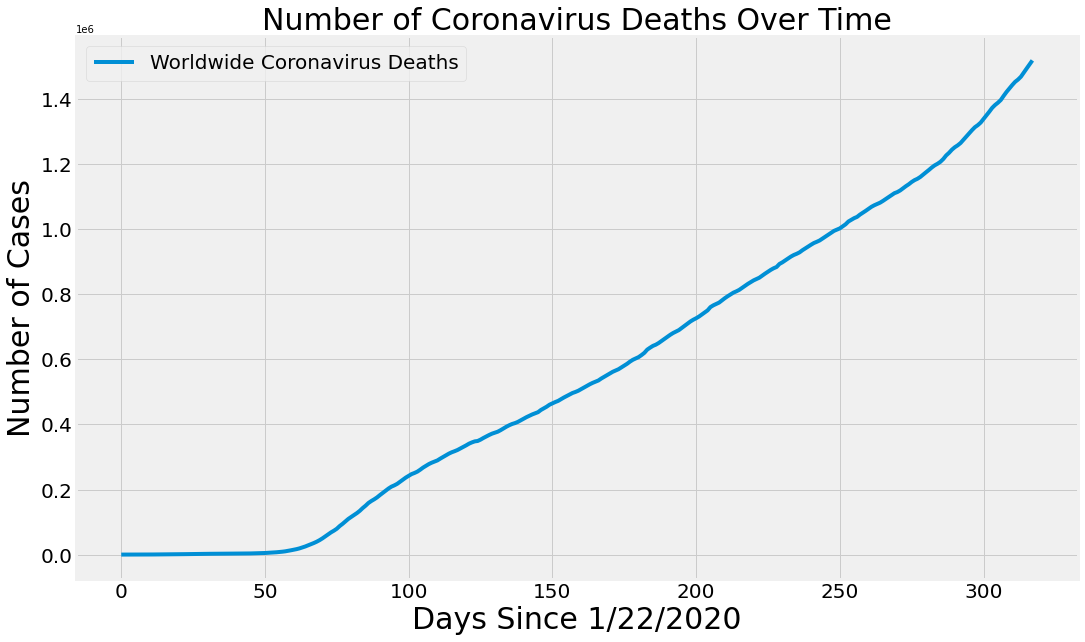

In [29]:
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, total_deaths)
#plt.plot(adjusted_dates, world_death_avg, linestyle='dashed', color='orange')
plt.title('Number of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Number of Cases', size=30)
plt.legend(['Worldwide Coronavirus Deaths', 'Moving Average {} Days'.format(window)], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

##World Recovered Cases

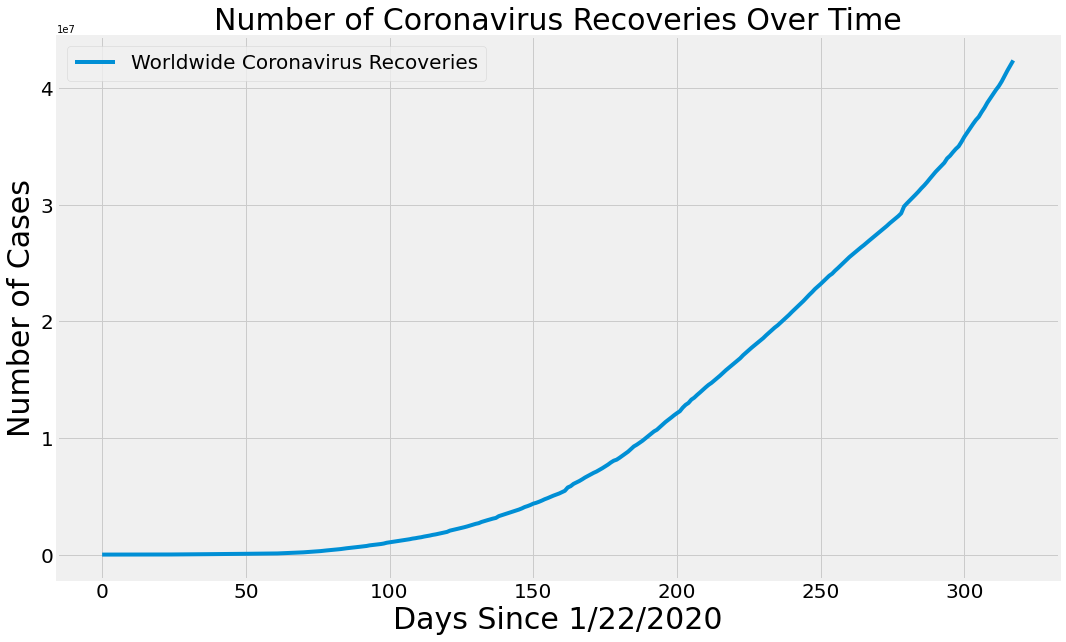

In [30]:
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, total_recovered)
#plt.plot(adjusted_dates, world_recovery_avg, linestyle='dashed', color='orange')
plt.title('Number of Coronavirus Recoveries Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Number of Cases', size=30)
plt.legend(['Worldwide Coronavirus Recoveries', 'Moving Average {} Days'.format(window)], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

##World Active Cases

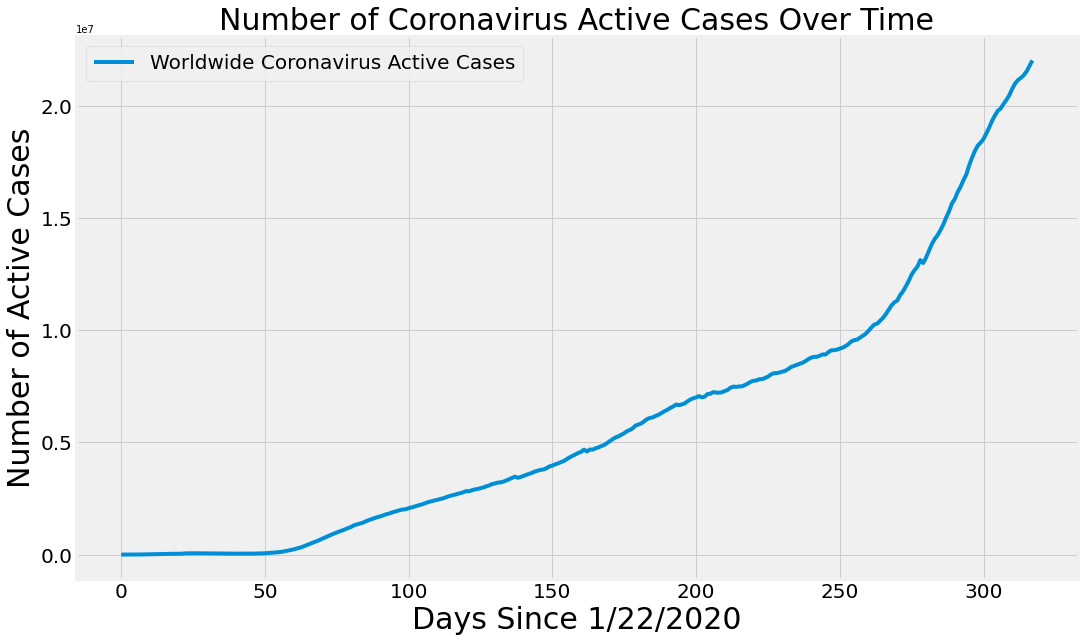

In [31]:
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, total_active)
#plt.plot(adjusted_dates, world_active_avg, linestyle='dashed', color='orange')
plt.title('Number of Coronavirus Active Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Number of Active Cases', size=30)
plt.legend(['Worldwide Coronavirus Active Cases', 'Moving Average {} Days'.format(window)], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

##World Mortality Rate

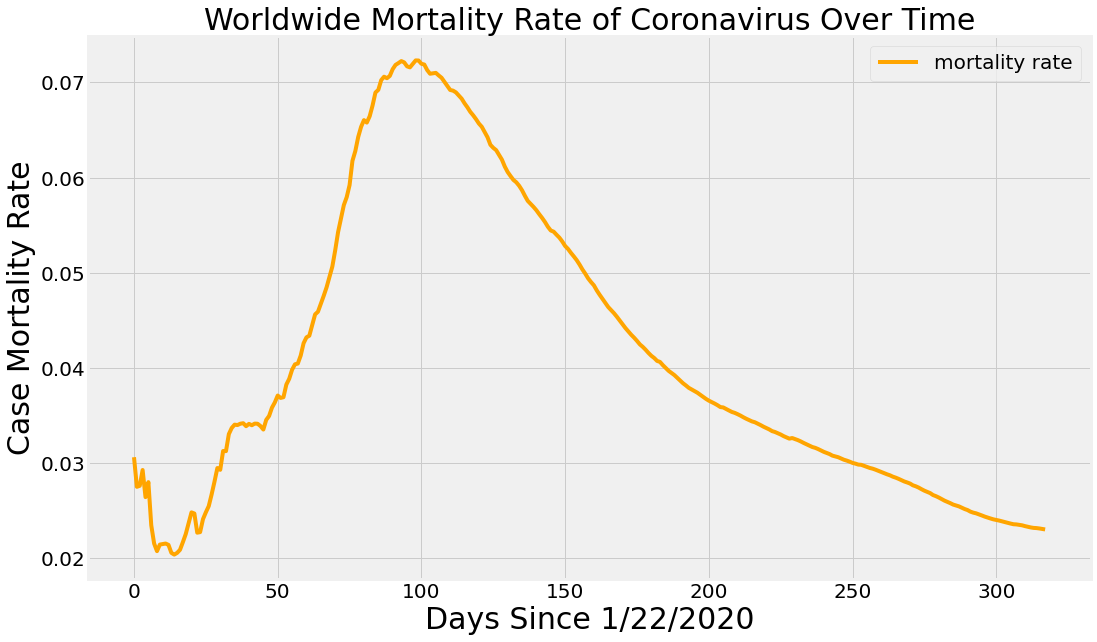

In [32]:
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, mortality_rate, color='orange')
#plt.axhline(y = mean_mortality_rate,linestyle='--', color='black')
plt.title('Worldwide Mortality Rate of Coronavirus Over Time', size=30)
plt.legend(['mortality rate', 'y='+str(mean_mortality_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Case Mortality Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

##World Recovery Rate

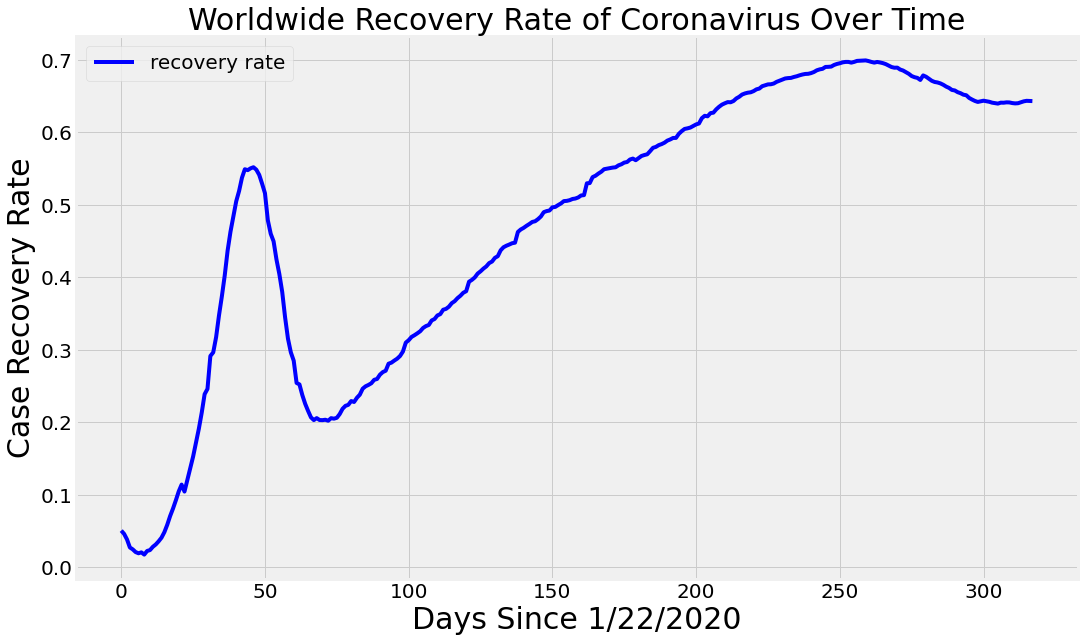

In [33]:
mean_recovery_rate = np.mean(recovery_rate)
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, recovery_rate, color='blue')
#plt.axhline(y = mean_recovery_rate,linestyle='--', color='black')
plt.title('Worldwide Recovery Rate of Coronavirus Over Time', size=30)
plt.legend(['recovery rate', 'y='+str(mean_recovery_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Case Recovery Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

##World Daily Average Confirmed Increase

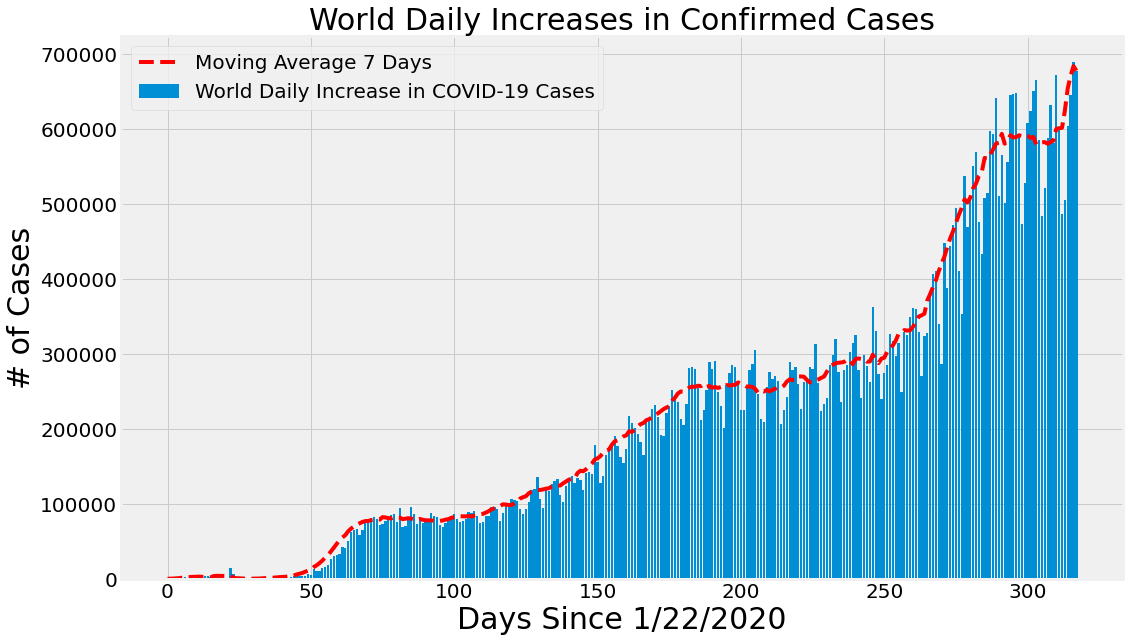

In [34]:
plt.figure(figsize=(16, 10))
plt.bar(adjusted_dates, world_daily_increase)
plt.plot(adjusted_dates, world_daily_increase_avg, color='red', linestyle='dashed')
plt.title('World Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Moving Average {} Days'.format(window), 'World Daily Increase in COVID-19 Cases'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

##World Daily Average Death Increase

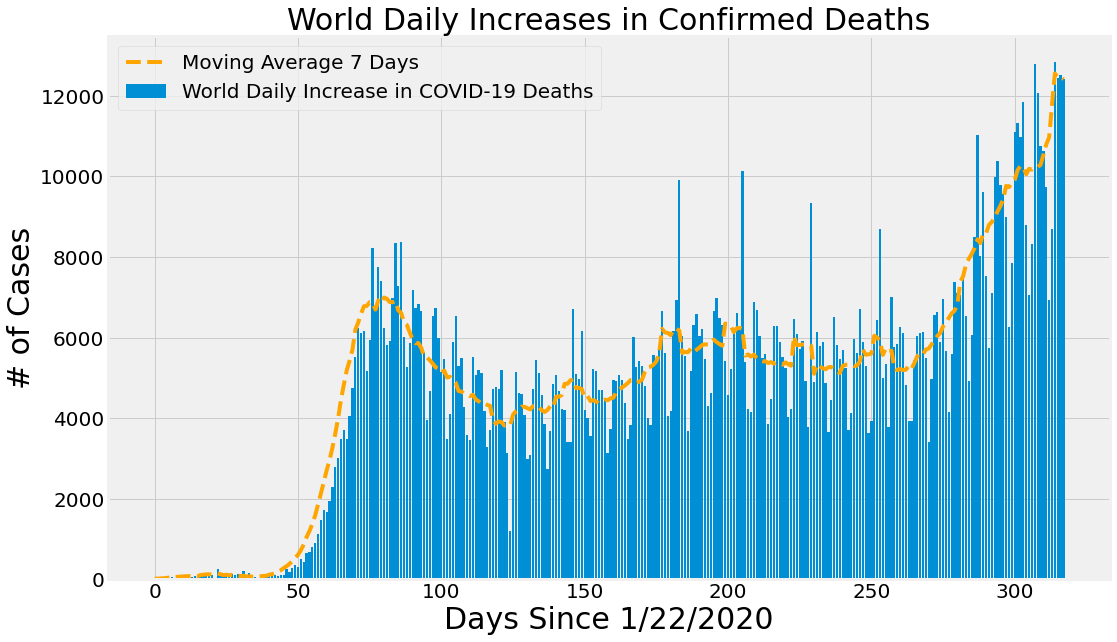

In [35]:
plt.figure(figsize=(16, 10))
plt.bar(adjusted_dates, world_daily_death)
plt.plot(adjusted_dates, world_daily_death_avg, color='orange', linestyle='dashed')
plt.title('World Daily Increases in Confirmed Deaths', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Moving Average {} Days'.format(window), 'World Daily Increase in COVID-19 Deaths'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

##World Daily Average Recovered Increase

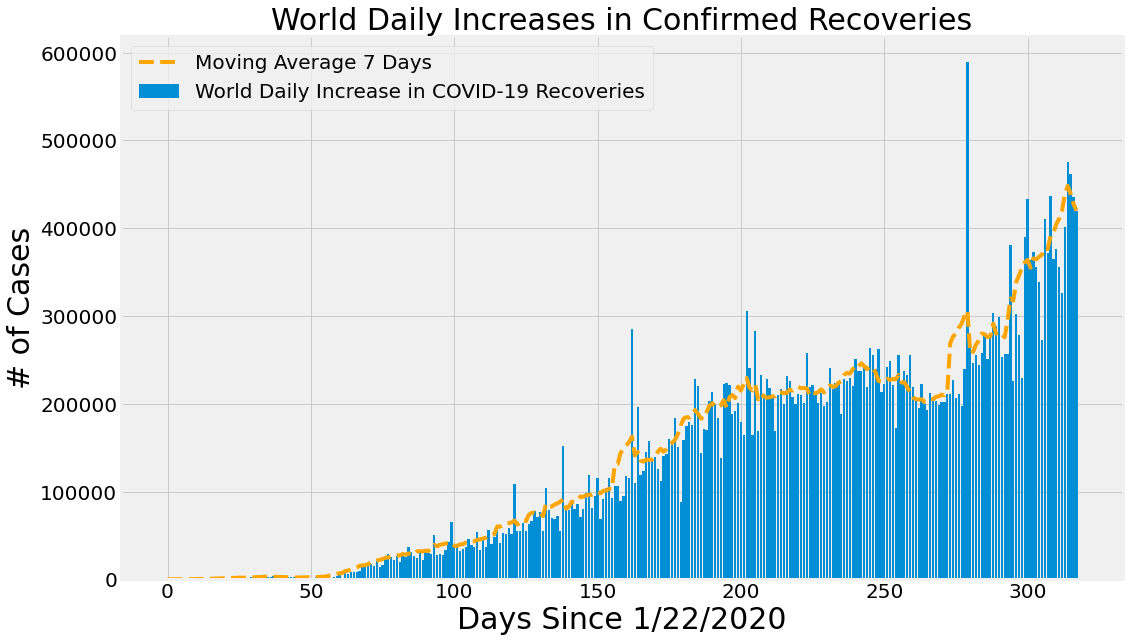

In [36]:
plt.figure(figsize=(16, 10))
plt.bar(adjusted_dates, world_daily_recovery)
plt.plot(adjusted_dates, world_daily_recovery_avg, color='orange', linestyle='dashed')
plt.title('World Daily Increases in Confirmed Recoveries', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Moving Average {} Days'.format(window), 'World Daily Increase in COVID-19 Recoveries'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

##Top 20 Current Hardest Hit Countries

In [37]:
unique_countries =  list(latest_data['Country_Region'].unique())
unique_countries

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burma',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Diamond Princess',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Grenada',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',

In [38]:
country_confirmed_cases = []
country_death_cases = [] 
country_active_cases = []
country_recovery_cases = []
country_incidence_rate = [] 
country_mortality_rate = [] 

no_cases = []
for i in unique_countries:
    cases = latest_data[latest_data['Country_Region']==i]['Confirmed'].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    
# sort countries by the number of confirmed cases
unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_data[latest_data['Country_Region']==unique_countries[i]]['Confirmed'].sum()
    country_death_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Deaths'].sum())
    country_recovery_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Recovered'].sum())
    country_active_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Active'].sum())
    country_incidence_rate.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Incident_Rate'].sum())
    country_mortality_rate.append(country_death_cases[i]/country_confirmed_cases[i])

In [39]:
country_df = pd.DataFrame({'Country Name': unique_countries, 'Number of Confirmed Cases': country_confirmed_cases,
                          'Number of Deaths': country_death_cases, 'Number of Recoveries' : country_recovery_cases, 
                          'Number of Active Cases' : country_active_cases, 'Incidence Rate' : country_incidence_rate,
                          'Mortality Rate': country_mortality_rate})
# number of cases per country/region

country_df.head(20).style.background_gradient(cmap='Oranges')

,Country Name,Number of Confirmed Cases,Number of Deaths,Number of Recoveries,Number of Active Cases,Incidence Rate,Mortality Rate
0,US,13383370,266873,5065030,8051417.000000,14416109.322383,0.019941
1,India,9431691,137139,8847600,446952.000000,34641.315688,0.014540
2,Brazil,6314740,172833,5581436,560471.000000,107465.434749,0.027370
3,France,2270573,52410,167005,2051158.000000,21828.842951,0.023082
4,Russia,2249890,39127,1746279,464484.000000,134718.632617,0.017391
5,Spain,1628208,44668,150376,1433164.000000,68208.100333,0.027434
6,United Kingdom,1621305,58342,3514,1559449.000000,17415.979829,0.035985
7,Italy,1585178,54904,734503,795771.000000,53517.056883,0.034636
8,Argentina,1418807,38473,1249843,130491.000000,3139.246837,0.027116
9,Colombia,1308376,36584,1204452,67340.000000,75164.741195,0.027961


##Current Hardest Hit Countries (Pie-Chart)

In [40]:
def plot_pie_charts(x, y, title):
    # more muted color 
    c = ['lightcoral', 'rosybrown', 'sandybrown', 'navajowhite', 'gold',
        'khaki', 'lightskyblue', 'turquoise', 'lightslategrey', 'thistle', 'pink']
    plt.figure(figsize=(20,15))
    plt.title(title, size=20)
    plt.pie(y, colors=c,shadow=True, labels=y)
    plt.legend(x, loc='best', fontsize=12)
    plt.show()

In [41]:
# Only show 15 countries with the most confirmed cases, the rest are grouped into the other category
visual_unique_countries = [] 
visual_confirmed_cases = []
others = np.sum(country_confirmed_cases[10:])

for i in range(len(country_confirmed_cases[:10])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(country_confirmed_cases[i])
    
visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

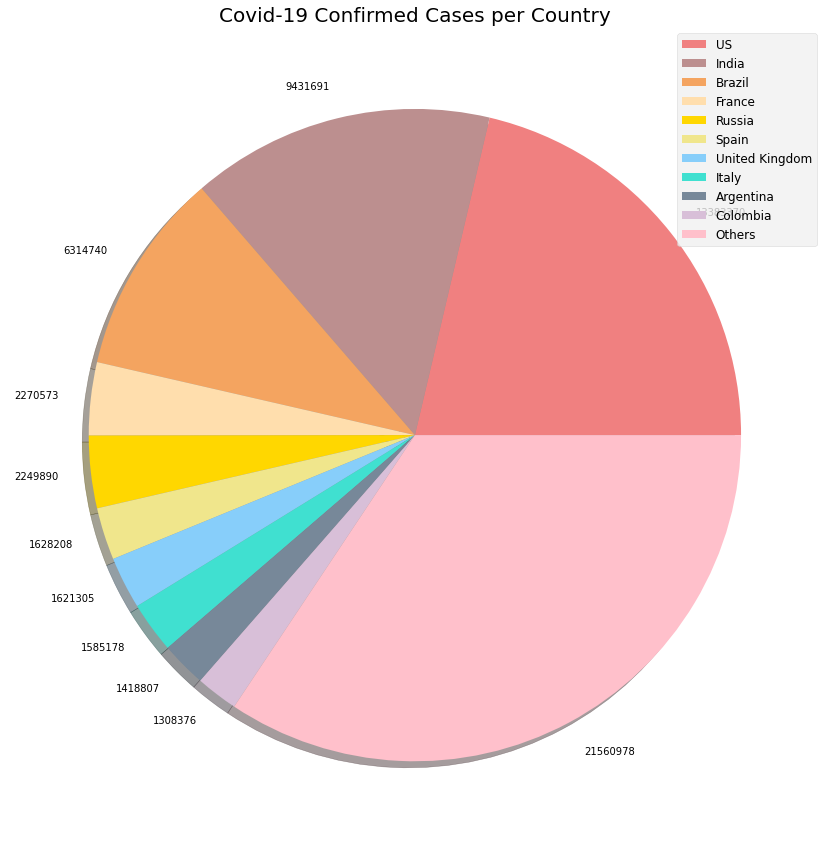

In [42]:
plot_pie_charts(visual_unique_countries, visual_confirmed_cases, 'Covid-19 Confirmed Cases per Country')

##Indonesian Cases



Confirmed, Daily Avg Confirmed Increase, Daily Avg Death Increase, Daily Avg Recovered Increase.

In [43]:
def country_plot(x, y1, x1, x2, x3, y2, y3, y4, country):
    # window is set as 14 in in the beginning of the notebook 
    confirmed_avg = moving_average(y1, window)
    confirmed_increase_avg = moving_average(y2, window)
    death_increase_avg = moving_average(y3, window)
    recovery_increase_avg = moving_average(y4, window)
    
    plt.figure(figsize=(16, 10))
    #plt.plot(x, y1)
    plt.plot(x, x1, color='blue')
    plt.plot(x, x2, color='green')
    plt.plot(x, x3, color='red')
    #plt.plot(x, confirmed_avg, color='red', linestyle='dashed')
    plt.legend(['{} Active Cases'.format(country), '{} Recovered Cases'.format(country), '{} Death Cases'.format(country)], prop={'size': 20})
    plt.title('{} Coronavirus Cases'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 10))
    plt.bar(x, y2)
    plt.plot(x, confirmed_increase_avg, color='red', linestyle='dashed')
    plt.legend(['Moving Average {} Days'.format(window), '{} Daily Increase in Confirmed Cases'.format(country)], prop={'size': 20})
    plt.title('{} Daily Increases in Confirmed Cases'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 10))
    plt.bar(x, y3)
    plt.plot(x, death_increase_avg, color='red', linestyle='dashed')
    plt.legend(['Moving Average {} Days'.format(window), '{} Daily Increase in Confirmed Deaths'.format(country)], prop={'size': 20})
    plt.title('{} Daily Increases in Deaths'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 10))
    plt.bar(x, y4)
    plt.plot(x, recovery_increase_avg, color='red', linestyle='dashed')
    plt.legend(['Moving Average {} Days'.format(window), '{} Daily Increase in Confirmed Recoveries'.format(country)], prop={'size': 20})
    plt.title('{} Daily Increases in Recoveries'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()
      
# helper function for getting country's cases, deaths, and recoveries        
def get_country_info(country_name):
    country_cases = []
    country_deaths = []
    country_recoveries = []  
    
    for i in dates:
        country_cases.append(confirmed_df[confirmed_df['Country/Region']==country_name][i].sum())
        country_deaths.append(deaths_df[deaths_df['Country/Region']==country_name][i].sum())
        country_recoveries.append(recoveries_df[recoveries_df['Country/Region']==country_name][i].sum())
    return (country_cases, country_deaths, country_recoveries)
    
    
def country_visualizations(country_name):
    country_info = get_country_info(country_name)
    country_cases = country_info[0]
    country_deaths = country_info[1]
    country_recoveries = country_info[2]
    country_actives = pd.DataFrame(country_info).apply(lambda col: col[0]-(col[1]+col[2]))
    
    country_daily_increase = daily_increase(country_cases)
    country_daily_death = daily_increase(country_deaths)
    country_daily_recovery = daily_increase(country_recoveries)
    
    country_plot(adjusted_dates, country_cases, country_actives, country_recoveries, country_deaths, country_daily_increase, country_daily_death, country_daily_recovery, country_name)
    

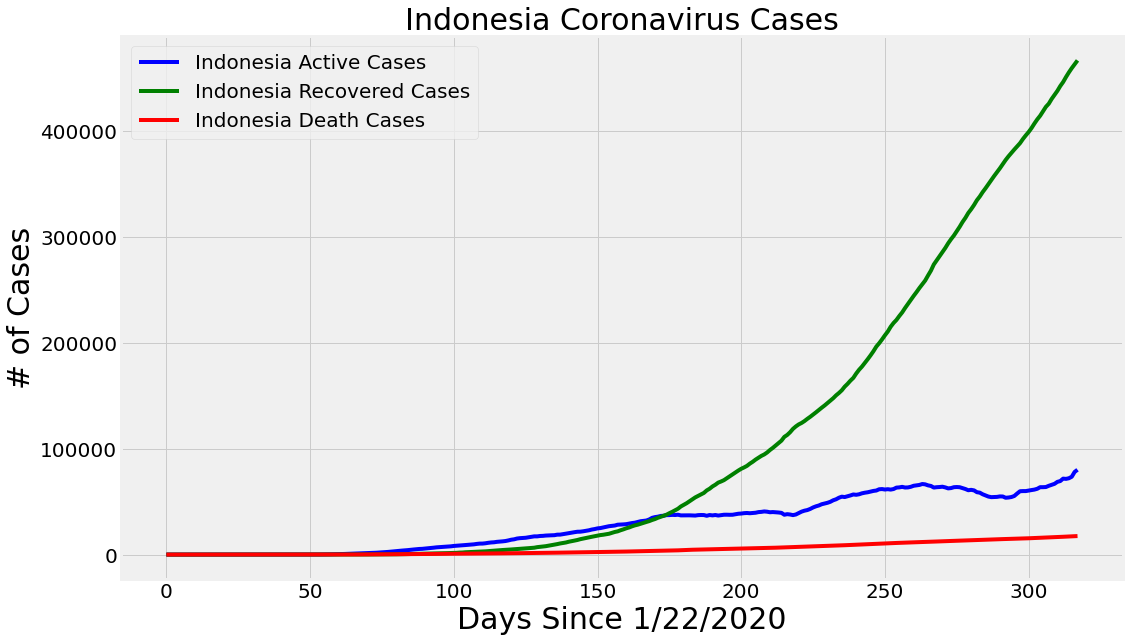

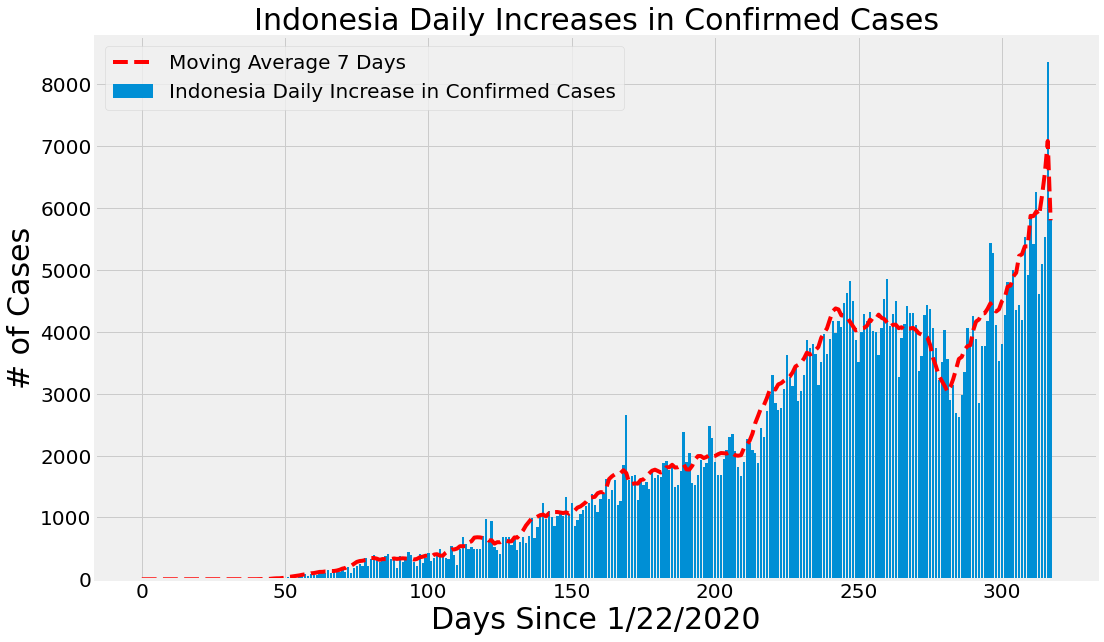

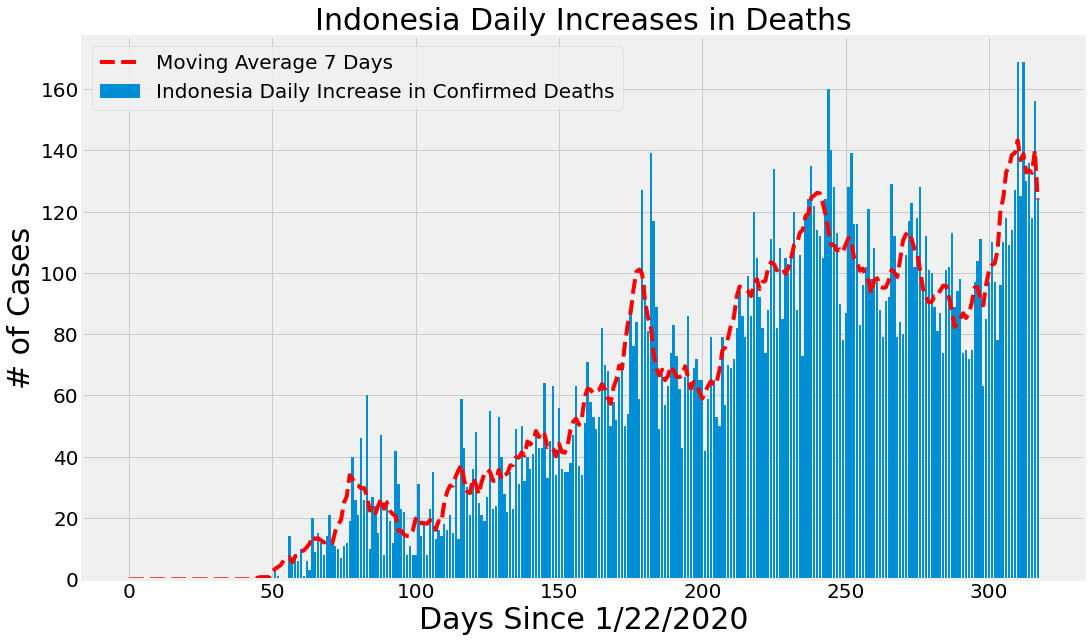

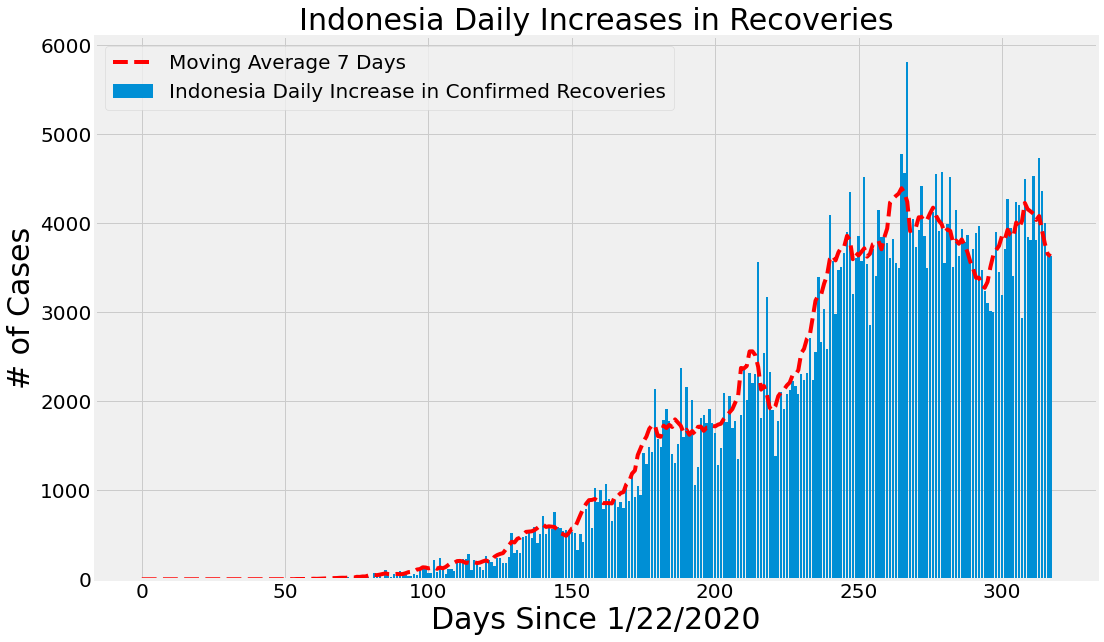

In [44]:
countries = ['Indonesia']
for country in countries:
    country_visualizations(country)

##Neighboring Countries Cases

Confirmed, Death, Recovered.

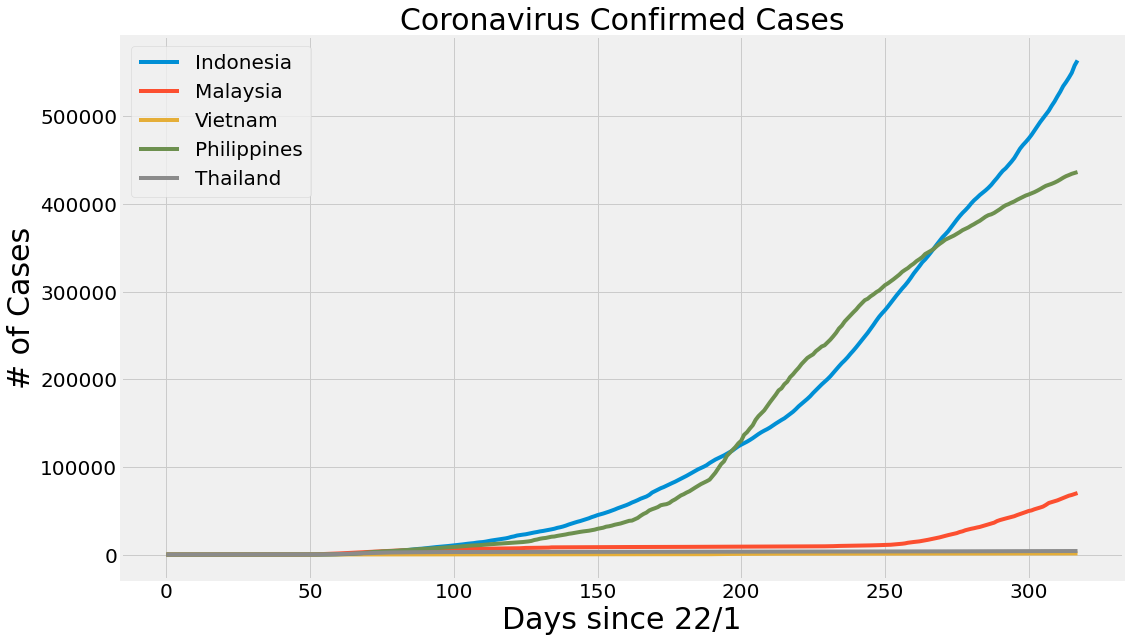

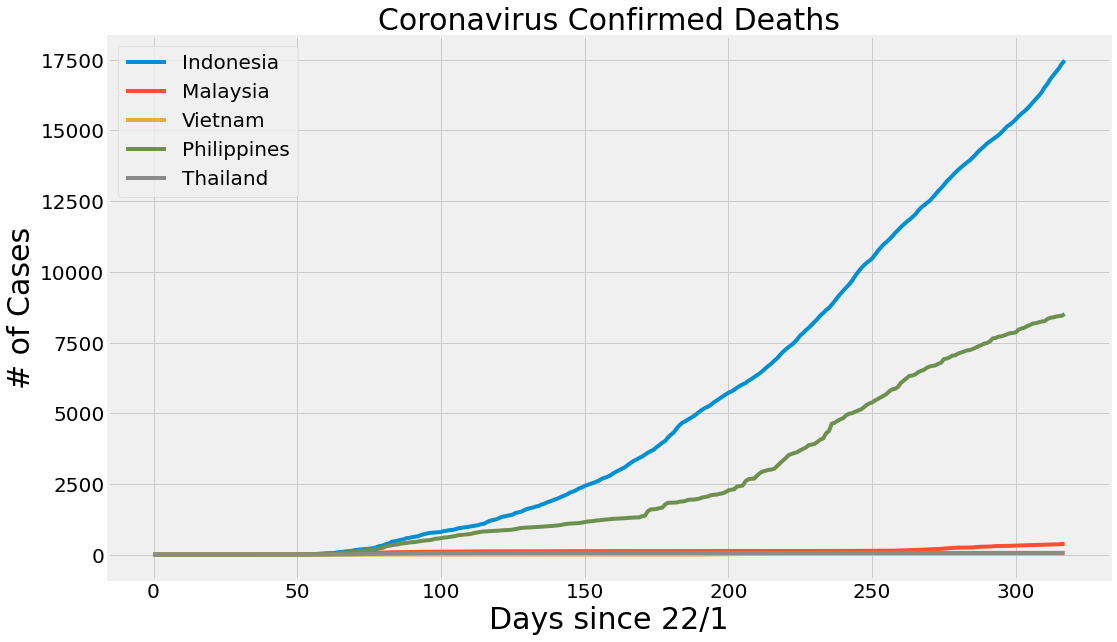

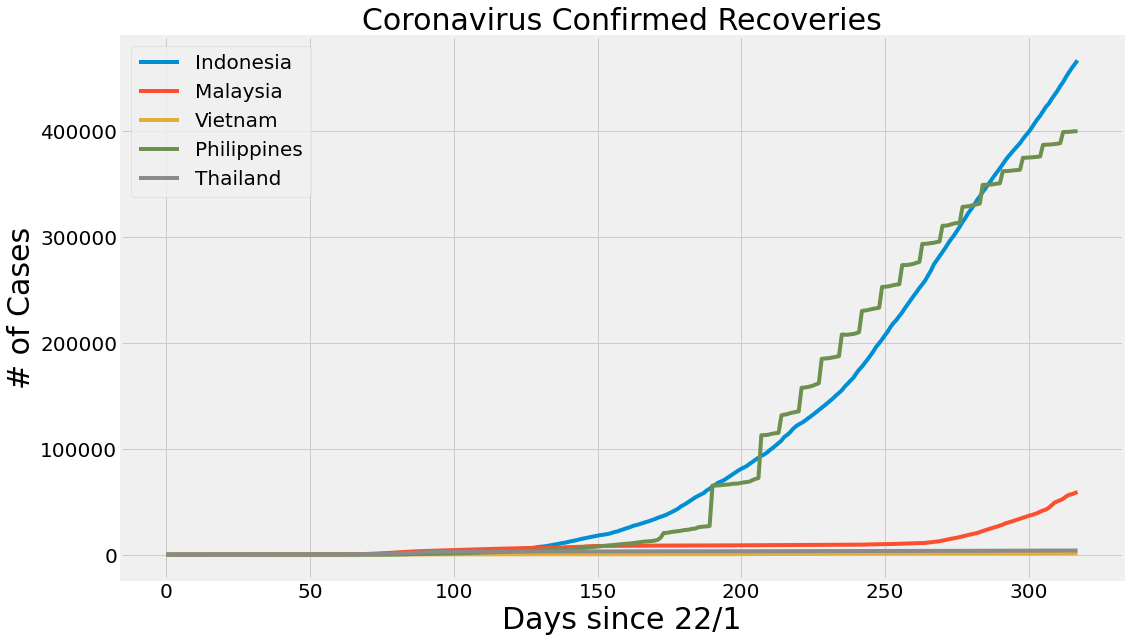

In [45]:
compare_countries = ['Indonesia', 'Malaysia', 'Vietnam', 'Philippines', 'Thailand']
graph_name = ['Coronavirus Confirmed Cases', 'Coronavirus Confirmed Deaths', 'Coronavirus Confirmed Recoveries']

for num in range(3):
    plt.figure(figsize=(16, 10))
    for country in compare_countries:
        plt.plot(get_country_info(country)[num])
    plt.legend(compare_countries, prop={'size': 20})
    plt.xlabel('Days since 22/1', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.title(graph_name[num], size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

##World Confirmed Cases Animation


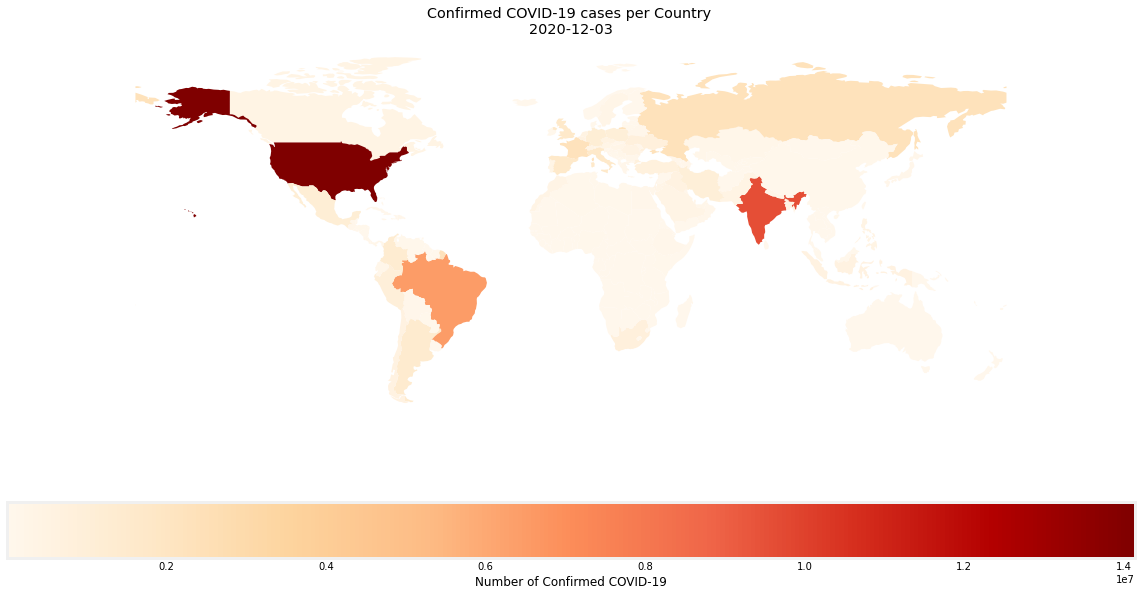

In [59]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

country_map = {'Bosnia and Herzegovina':'Bosnia and Herz.'
, 'Central African Republic':'Central African Rep.'
, "Cote d'Ivoire":"Côte d'Ivoire"
, 'Dominican Republic':'Dominican Rep.'
, 'Equatorial Guinea':'Eq. Guinea'
, 'Eswatini':'eSwatini'
, 'South Sudan':'S. Sudan'
, 'Taiwan*':'Taiwan'
, 'US':'United States of America'
, 'Western Sahara':'W. Sahara'
, 'Congo (Kinshasa)':'Congo'
, 'Congo (Brazzaville)': 'Dem. Rep. Congo'}

new_df2 = new_df

new_df2['Country'] = new_df2['Country/Region'].map(country_map)
new_df2.loc[~new_df2['Country'].notnull(), 'Country'] = new_df2.loc[~new_df2['Country'].notnull(), 'Country/Region']

new_df2["Date"] = pd.to_datetime(new_df2["Date"])

cworld = world.merge(new_df2,how= 'left',left_on='name',right_on='Country')
cworld = cworld[cworld.name!="Antarctica"]
cworld.Confirmed = cworld.Confirmed.fillna(0)
cworld['Confirmed Per Pop'] = cworld.apply(lambda x: x.Confirmed/x.pop_est, axis=1)
#cworld['Recovery Rate'] = cworld.apply(lambda x: x.Recoveries/x.Confirmed, axis=1)
#cworld['Mortality Rate'] = cworld.apply(lambda x: x.Death/x.Confirmed, axis=1)
cworld['Active Cases'] = cworld.apply(lambda x: x.Confirmed - (x.Death + x.Recoveries), axis=1)
cworld['Active Cases Per Pop'] = cworld.apply(lambda x: (x.Confirmed - (x.Death + x.Recoveries))/x.pop_est, axis=1)

def make_graph_confirmed(date,data):

	data = data[data["Date"] == date].reset_index(drop=True)

	#Generate the choropleth map using gdf plot function on the Confirmed 
	columnfig = data.plot(column='Confirmed',cmap='OrRd',figsize=(18,10), legend = True
	            ,legend_kwds={'label': "Number of Confirmed COVID-19",
	                          'orientation': "horizontal"})
	#removing axis ticks
	plt.axis('off')#Add the title
	plt.title("Confirmed COVID-19 cases per Country \n"+str(date.date()))
	#plt.show()

#tambahan iterator
#ITERASI CONFIRMED

start_date = datetime.datetime(2020, 12, 3)
end_date = datetime.datetime(2020, 12, 4)

# Generate an image for each day between start_date and end_date
for ii, days in enumerate(range((end_date - start_date).days)):
	date = start_date + datetime.timedelta(days)
	make_graph_confirmed(date,cworld)
#	images_dir = '/content/drive/MyDrive/Data Lain/Pemrograman Lanjutan/Frame Confirmed'
#	plt.savefig(f"{images_dir}/"+str(date)+".jpg")


##World Confirmed Cases per Capita Animation

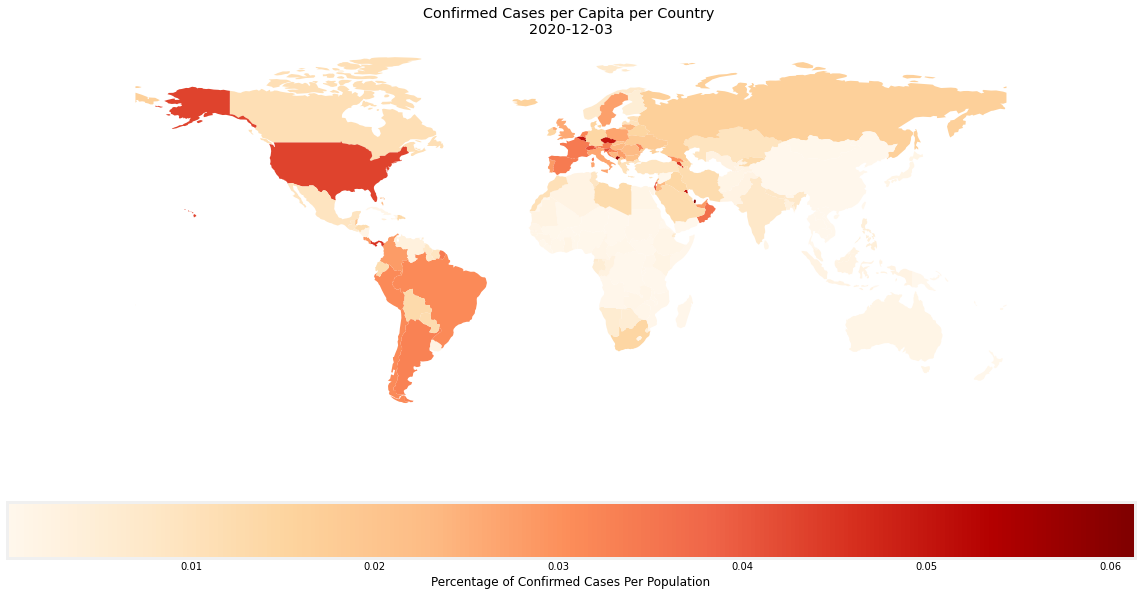

In [60]:
def make_graph_active_cases(date,data):

	data = data[data["Date"] == date].reset_index(drop=True)

	#Generate the choropleth map using gdf plot function on the Confirmed 
	columnfig = data.plot(column='Confirmed Per Pop',cmap='OrRd',figsize=(18,10), legend = True
	            ,legend_kwds={'label': "Percentage of Confirmed Cases Per Population",
	                          'orientation': "horizontal"})
	#removing axis ticks
	plt.axis('off')#Add the title
	plt.title("Confirmed Cases per Capita per Country \n"+str(date.date()))

#ITERASI 

start_date = datetime.datetime(2020, 12, 3)
end_date = datetime.datetime(2020, 12, 4)

# Generate an image for each day between start_date and end_date
for ii, days in enumerate(range((end_date - start_date).days)):
	date = start_date + datetime.timedelta(days)
	make_graph_active_cases(date,cworld)
#	images_dir = '/content/drive/MyDrive/Data Lain/Pemrograman Lanjutan/Frame Confirmed per Pop'
#	plt.savefig(f"{images_dir}/"+str(date)+".jpg")

##World Active Cases Animation

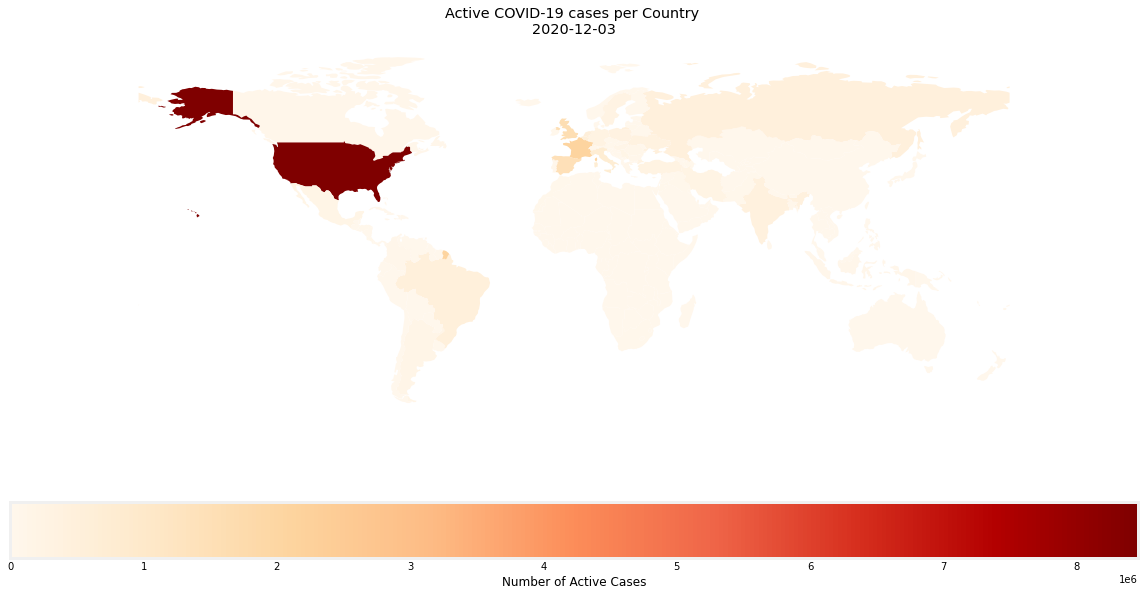

In [61]:
def make_graph_active_cases(date,data):

	data = data[data["Date"] == date].reset_index(drop=True)

	#Generate the choropleth map using gdf plot function on the Confirmed 
	columnfig = data.plot(column='Active Cases',cmap='OrRd',figsize=(18,10), legend = True
	            ,legend_kwds={'label': "Number of Active Cases",
	                          'orientation': "horizontal"})
	#removing axis ticks
	plt.axis('off')#Add the title
	plt.title("Active COVID-19 cases per Country \n"+str(date.date()))

#ITERASI 

start_date = datetime.datetime(2020, 12, 3)
end_date = datetime.datetime(2020, 12, 4)

# Generate an image for each day between start_date and end_date
for ii, days in enumerate(range((end_date - start_date).days)):
	date = start_date + datetime.timedelta(days)
	make_graph_active_cases(date,cworld)
#	images_dir = '/content/drive/MyDrive/Data Lain/Pemrograman Lanjutan/Frame Active'
#	plt.savefig(f"{images_dir}/"+str(date)+".jpg")

##World Active Cases per Capita Animation

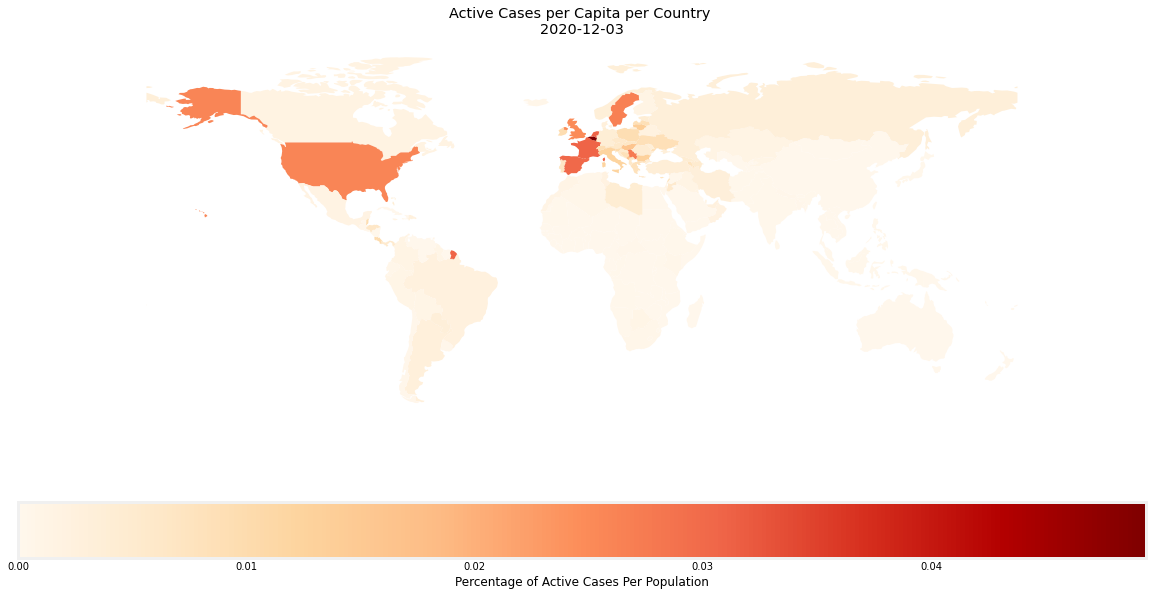

In [62]:
def make_graph_active_per_pop(date,data):

	data = data[data["Date"] == date].reset_index(drop=True)

	#Generate the choropleth map using gdf plot function on the Confirmed 
	columnfig = data.plot(column='Active Cases Per Pop',cmap='OrRd',figsize=(18,10), legend = True
	            ,legend_kwds={'label': "Percentage of Active Cases Per Population",
	                          'orientation': "horizontal"})
	#removing axis ticks
	plt.axis('off')#Add the title
	plt.title("Active Cases per Capita per Country \n"+str(date.date()))

#ITERASI 

start_date = datetime.datetime(2020, 12, 3)
end_date = datetime.datetime(2020, 12, 4)

# Generate an image for each day between start_date and end_date
for ii, days in enumerate(range((end_date - start_date).days)):
	date = start_date + datetime.timedelta(days)
	make_graph_active_per_pop(date,cworld)
#	images_dir = '/content/drive/MyDrive/Data Lain/Pemrograman Lanjutan/Frame Active per Pop'
#	plt.savefig(f"{images_dir}/"+str(date)+".jpg")

##World Confirmed Cases Prediction 

In [50]:
def plot_predictions(x, y, pred, algo_name, color):
    plt.figure(figsize=(16, 10))
    plt.plot(x, y)
    plt.plot(future_forcast, pred, linestyle='dashed', color=color)
    plt.title('Worldwide Coronavirus Cases Over Time', size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.legend(['Confirmed Cases', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

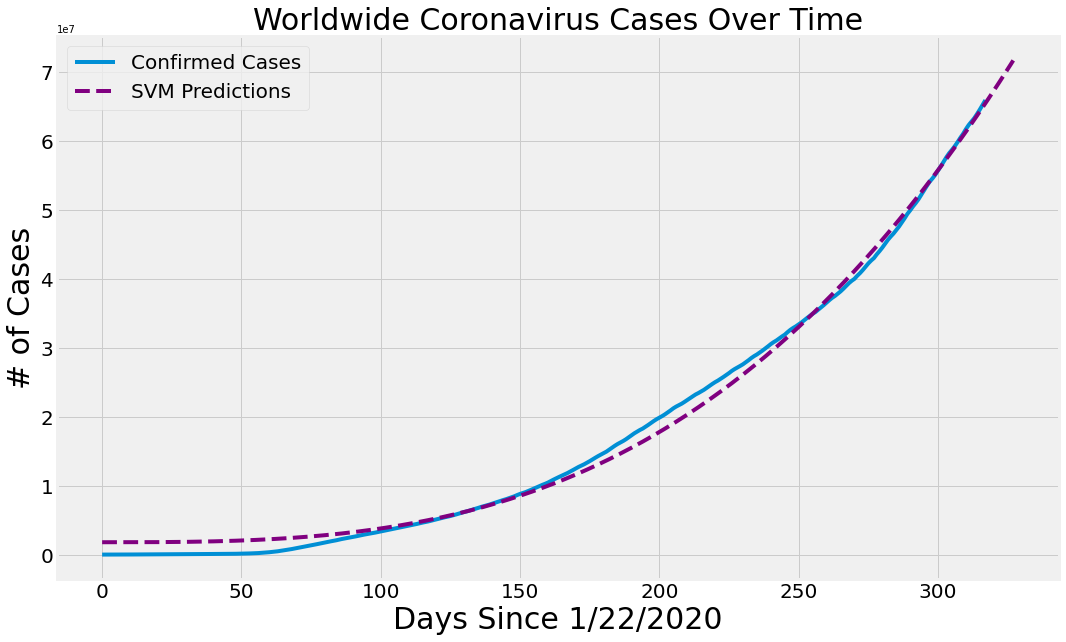

In [51]:
plot_predictions(adjusted_dates, world_cases, svm_pred, 'SVM Predictions', 'purple')

In [52]:
# Future predictions using SVM 
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'SVM Predicted # of Confirmed Cases Worldwide': np.round(svm_pred[-10:])})
svm_df.style.background_gradient(cmap='Reds')

,Date,SVM Predicted # of Confirmed Cases Worldwide
0,12/05/2020,66045391.000000
1,12/06/2020,66653454.000000
2,12/07/2020,67265341.000000
3,12/08/2020,67881064.000000
4,12/09/2020,68500635.000000
5,12/10/2020,69124067.000000
6,12/11/2020,69751371.000000
7,12/12/2020,70382559.000000
8,12/13/2020,71017643.000000
9,12/14/2020,71656636.000000


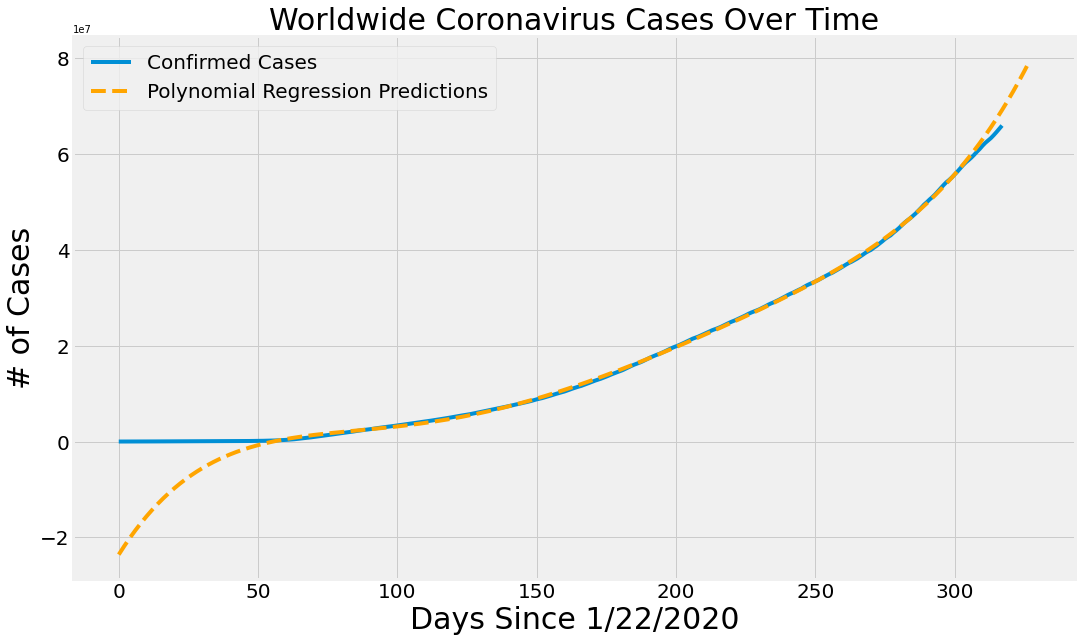

In [53]:
plot_predictions(adjusted_dates, world_cases, linear_pred, 'Polynomial Regression Predictions', 'orange')

In [54]:
# Future predictions using polynomial regression
linear_pred = linear_pred.reshape(1,-1)[0]
linear_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Polynomial Predicted # of Confirmed Cases Worldwide': np.round(linear_pred[-10:])})
linear_df.style.background_gradient(cmap='Reds')

,Date,Polynomial Predicted # of Confirmed Cases Worldwide
0,12/05/2020,70067177.000000
1,12/06/2020,71029499.000000
2,12/07/2020,72011821.000000
3,12/08/2020,73014575.000000
4,12/09/2020,74038198.000000
5,12/10/2020,75083133.000000
6,12/11/2020,76149831.000000
7,12/12/2020,77238748.000000
8,12/13/2020,78350347.000000
9,12/14/2020,79485096.000000


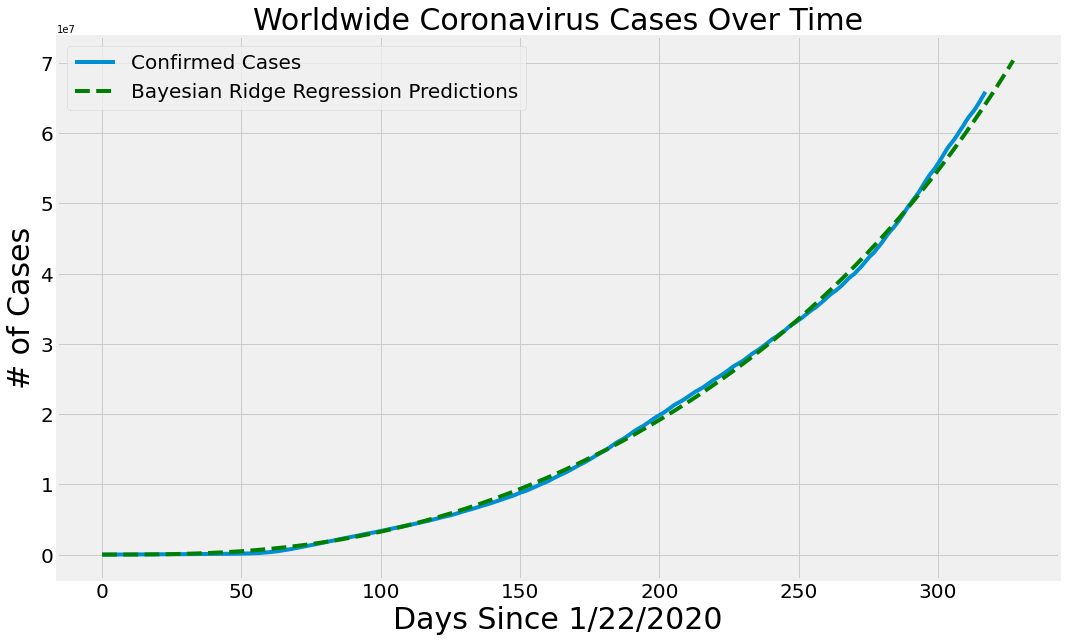

In [55]:
plot_predictions(adjusted_dates, world_cases, bayesian_pred, 'Bayesian Ridge Regression Predictions', 'green')

In [56]:
# Future predictions using Bayesian Ridge 
bayesian_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Bayesian Ridge Predicted # of Confirmed Cases Worldwide': np.round(bayesian_pred[-10:])})
bayesian_df.style.background_gradient(cmap='Reds')

,Date,Bayesian Ridge Predicted # of Confirmed Cases Worldwide
0,12/05/2020,64735218.000000
1,12/06/2020,65339110.000000
2,12/07/2020,65948334.000000
3,12/08/2020,66562947.000000
4,12/09/2020,67183006.000000
5,12/10/2020,67808568.000000
6,12/11/2020,68439694.000000
7,12/12/2020,69076442.000000
8,12/13/2020,69718871.000000
9,12/14/2020,70367043.000000
